# Statistical Learning.- Targetting Users

In [20]:
import io
import os
import json
import numpy as np
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency

In [2]:
PATH = '../../data/'
df_frame = pd.read_csv(PATH + 'feature_frame.csv', engine='pyarrow')
pd.set_option('display.max_columns', None)

**Filtramos el datase para obtener el dataset objetivo**

In [3]:
def filter_orders(data):
    order_counts = data.groupby('order_id')['outcome'].sum().reset_index(name='products_bought')
    filtered_orders = order_counts[order_counts['products_bought'] >= 5]
    final_dataframe = data[data['order_id'].isin(filtered_orders['order_id'])]
    return final_dataframe

df = filter_orders(data=df_frame)
print(df.head())
print('\n')
print("Número de filas:", df.shape[0])

       variant_id     product_type       order_id        user_id  \
0  33826472919172  ricepastapulses  2807985930372  3482464092292   
1  33826472919172  ricepastapulses  2808027644036  3466586718340   
2  33826472919172  ricepastapulses  2808099078276  3481384026244   
3  33826472919172  ricepastapulses  2808393957508  3291363377284   
5  33826472919172  ricepastapulses  2808434524292  3479090790532   

           created_at order_date  user_order_seq  outcome  ordered_before  \
0 2020-10-05 16:46:19 2020-10-05               3      0.0             0.0   
1 2020-10-05 17:59:51 2020-10-05               2      0.0             0.0   
2 2020-10-05 20:08:53 2020-10-05               4      0.0             0.0   
3 2020-10-06 08:57:59 2020-10-06               2      0.0             0.0   
5 2020-10-06 10:50:23 2020-10-06               3      0.0             0.0   

   abandoned_before  active_snoozed  set_as_regular  normalised_price  \
0               0.0             0.0             0.0    

In [9]:
print(df.columns)
nuemric = ['avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id','avg_days_to_buy_product_type','std_days_to_buy_product_type',            'normalised_price', 'discount_pct', 'global_popularity']

ordinal = ['user_order_seq', 'count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby', 'days_since_purchase_variant_id', 'days_since_purchase_product_type']

categrorical = ['variant_id', 'product_type', 'order_id', 'user_id','outcome','ordered_before',
                'abandoned_before', 'active_snoozed', 'set_as_regular','vendor']

date = ['created_at', 'order_date']

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')


In [30]:
df[ordinal] = df[ordinal].astype(np.int64)
df[['outcome', 'ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']] = df[['outcome', 'ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']].astype(np.int64)
df[nuemric] = df[nuemric].astype(np.float64)

/tmp/ipykernel_35296/2188528641.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ordinal] = df[ordinal].astype(np.int64)
/tmp/ipykernel_35296/2188528641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['outcome', 'ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']] = df[['outcome', 'ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']].astype(np.int64)
/tmp/ipykernel_35296/2188528641.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy o

Ya se comprobó en EDA pero de nuevo miraremos los null values

In [ ]:
def count_null_values(df):
    null_counts = df.isna().sum()
    null_dict = null_counts.to_dict()
    return null_dict
count_null_values(df=df)

# Feature selection

En la anterior entrega no chequamos las correlaciones entre variables ordinale/categoricas. Primero mostraremos la correlacion entre las variables de descripcion familiar. 
Nos quedaremos con las variables 'count_babies' y 'people_ex_baby' ya que describen suficientemente bien la estructura familiar del cliente.

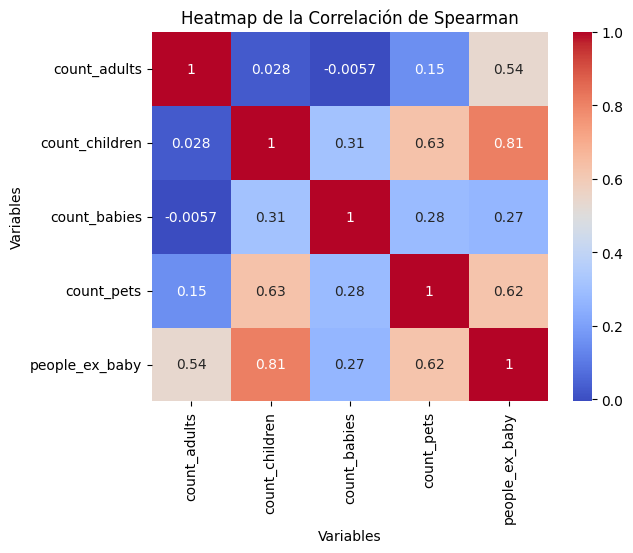

In [50]:
ppl_df = df[['count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby']]
correlation_matrix, _ = spearmanr(ppl_df)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=['count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby'], yticklabels=['count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby'])

plt.xlabel('Variables')
plt.ylabel('Variables')
plt.title('Heatmap de la Correlación de Spearman')
plt.show()

In [34]:
df = df.drop(['count_adults', 'count_children', 'count_pets'], axis=1)

Tambien miraremos la correlacion de spearman de las variables days_to. Mantendremos todas las variables

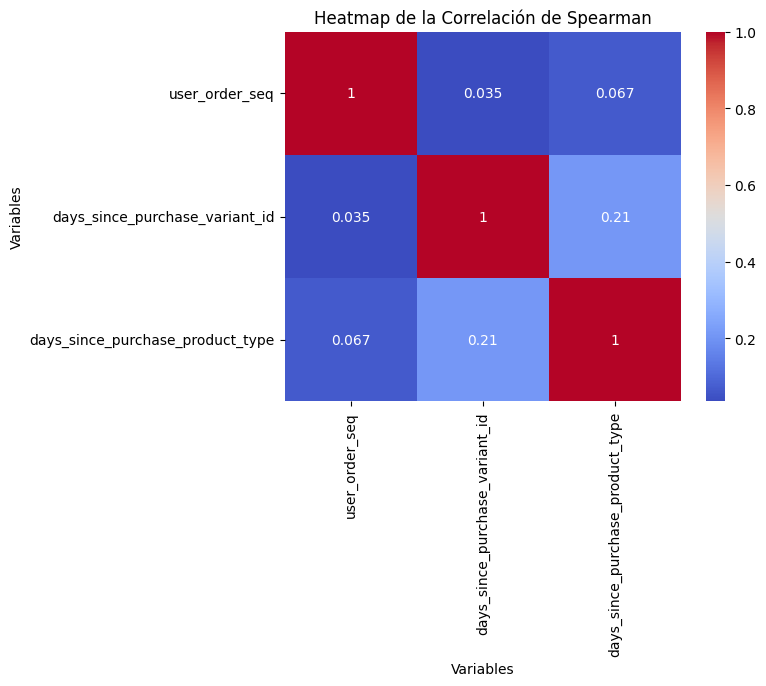

In [49]:
days_pd = df[['user_order_seq', 'days_since_purchase_variant_id', 'days_since_purchase_product_type']]
correlation_matrix, _ = spearmanr(days_pd)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=['user_order_seq', 'days_since_purchase_variant_id', 'days_since_purchase_product_type'], yticklabels=['user_order_seq', 'days_since_purchase_variant_id', 'days_since_purchase_product_type'])
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.title('Heatmap de la Correlación de Spearman')
plt.show()

Ahora a las variabels categoricas

In [37]:
cat_df = df[['variant_id', 'product_type', 'order_id', 'user_id','outcome','ordered_before',
                'abandoned_before', 'active_snoozed', 'set_as_regular','vendor']].reset_index()

mapeo_banrio = {1: 'Si', 0:'No'}
cat_df['ordered_before'] = cat_df['ordered_before'].replace(mapeo_banrio)
cat_df['abandoned_before'] = cat_df['abandoned_before'].replace(mapeo_banrio)
cat_df['active_snoozed'] = cat_df['active_snoozed'].replace(mapeo_banrio)
cat_df['set_as_regular'] = cat_df['set_as_regular'].replace(mapeo_banrio)
 
Crosstab=pd.crosstab(index=df['vendor'],columns=df['product_type'])
ChiSqResult = chi2_contingency(Crosstab)
print('The P-Value of the ChiSq Test1 is:', ChiSqResult[1])

Crosstab=pd.crosstab(index=df['ordered_before'],columns=df['abandoned_before'])
ChiSqResult = chi2_contingency(Crosstab)
print('The P-Value of the ChiSq Test2 is:', ChiSqResult[1])

Crosstab=pd.crosstab(index=df['ordered_before'],columns=df['set_as_regular'])
ChiSqResult = chi2_contingency(Crosstab)
print('The P-Value of the ChiSq Test2 is:', ChiSqResult[1])

Crosstab=pd.crosstab(index=df['active_snoozed'],columns=df['abandoned_before'])
ChiSqResult = chi2_contingency(Crosstab)
print('The P-Value of the ChiSq Test2 is:', ChiSqResult[1])
 
# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)

The P-Value of the ChiSq Test1 is: 0.0
The P-Value of the ChiSq Test2 is: 0.0
The P-Value of the ChiSq Test2 is: 0.0
The P-Value of the ChiSq Test2 is: 4.744305675762013e-86


Debemos mantener todas las variables categoricas/binarias segun el test chi-cuadrado. Muy probablemente debido a lo desbalanceados que estan. (Curiosisdad: si se explora la cross table vendor - product type, se observa que los vendedores son 'raramente' muy especialistas en el tipo de productos que proveen a la tienda. Puede que la categorizacion de product type sea poco generalista)

Sobre las variables numericas, se ha decidido eliminar las variables std_days_to... ya que esa informacion queda parcialmente recogida en su variable analoga avg_days_to y las correlaciones eran de >=0.30 (este paso es bastante cuestionable, pero elimina complejidad al modelo). Como ya se comentó, las variables ordinales presentan mucha variabilidad y sobre las variables estrictamente numericas, hay mas variabilidad en las referentes a items que no a product type (como es esperable). No se ha considerado necesario limpiar outliers (claros) ya que por lo general son outliers referetnes a productos que se compran con mucha frecuencia, relevantes y que aportaran info crucial al modelo (no eliminaremos outliers)

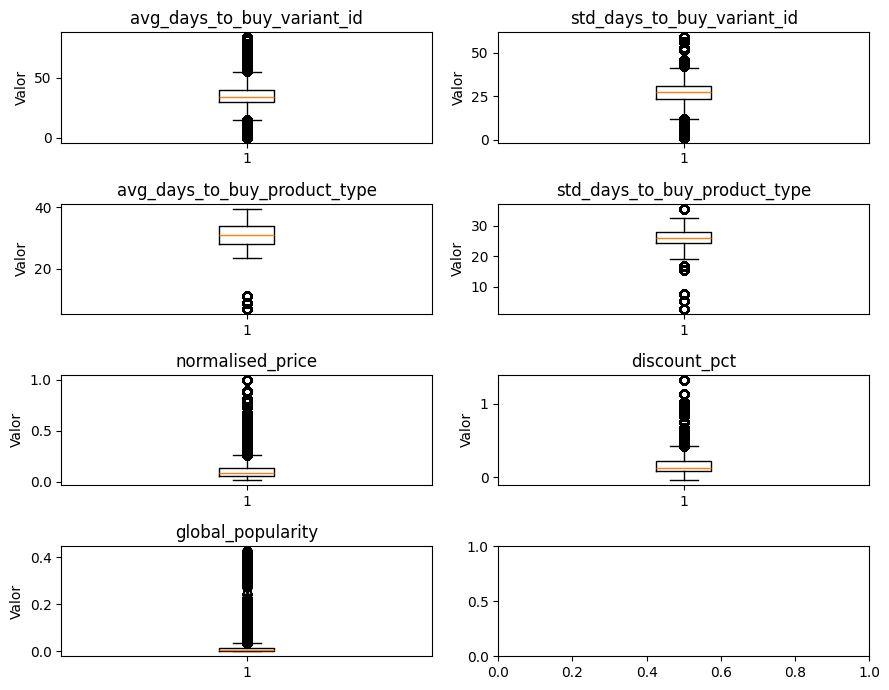

In [38]:
filas = (len(nuemric) + 1) // 2

fig, axes = plt.subplots(filas, 2, figsize=(9,7))
for i, cols in enumerate(nuemric):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    ax.boxplot(df[cols])
    ax.set_title(f'{cols}')
    ax.set_ylabel('Valor')
plt.tight_layout()
plt.show()

In [39]:
df = df.drop(['std_days_to_buy_variant_id','std_days_to_buy_product_type'], axis=1)

Para hacer encoding de las variables categoricas 'product_type' y 'vendor', se ha usado Frecuency encoding en vendor (ya que hay 264 categorias) y hot-encoding en product_type.

In [40]:
# Freq encoding
fe = df.groupby('vendor').size()
fe = fe/len(df)
df['vendor'] = df['vendor'].map(fe).round(2)

In [42]:
# Dummies Encoding
df = pd.get_dummies(df, columns=['product_type'], prefix='product', drop_first=True).astype(int).reset_index()

: 

Finalmente, nos quedaremos solo con la varible 'order_date' de las variables tipo Date (ausmiremos que no aporta info la hora del pedido) y crearemos tres columnas a partir de ella: Year, Month y Day_of_Year. Vimos en EDA que no habia estacionalidad en el timeline de orders, pero la varibale a solas 'day' estaría desvirtuando el momento de orden en el año 

In [ ]:
df.drop('created_at')

In [ ]:
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['day_of_year'] = df['order_date'].dt.day_of_year

# Scaling

Vimos en EDA que las variables numericas no estaban reescaladas (ni normalizadas) y eso puede llegar a penalizar nuestro modelo